In [1]:
import sys
sys.path.append('../code/') 
sys.path.append('../externals/transformer/') 
from tst import Transformer

import mocap_functions
from functools import partial
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
from hnn_core.utils import smooth_waveform
from scipy.signal import savgol_filter
#sns.set()
#sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

2023-03-08 21:50:02.919719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 21:50:03.228536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 21:50:03.228568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 21:50:03.271669: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-08 21:50:04.157329: W tensorflow/stream_executor/platform/de

In [2]:
cam_idx = 1
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/', kinematic_suffix=f'_cam{cam_idx}')
num_trials = len(kinematic_df['trial'].unique())

null_percent = kinematic_df.groupby('name')['posData'].apply(list).map(
    np.concatenate).map(lambda x: np.sum(np.isnan(x)) / len(x))

pos_filter = [1, 4]
pos_remove_filter = [f'position_{pos_idx}' for pos_idx in [2,3]]
# layout_filter = [1,2,3,4]
layout_filter = [1,2]

layout_remove_filter = [f'layout_{layout_idx}' for layout_idx in []]


neural_df = neural_df[np.in1d(neural_df['position'], pos_filter)].reset_index(drop=True)
neural_df = neural_df[np.in1d(neural_df['layout'], layout_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], pos_remove_filter)].reset_index(drop=True)
neural_df = neural_df[~np.in1d(neural_df['unit'], layout_remove_filter)].reset_index(drop=True)

kinematic_df = kinematic_df[np.in1d(kinematic_df['position'], pos_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[np.in1d(kinematic_df['layout'], layout_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], pos_remove_filter)].reset_index(drop=True)
kinematic_df = kinematic_df[~np.in1d(kinematic_df['name'], layout_remove_filter)].reset_index(drop=True)

In [3]:
# Subselect specific marker
# marker_list = ['ulnarDistal', 'carpal', 'thumbProx', 'ringProx','pinkyProx'] # cam4
marker_list = ['ringProx', 'pinkyProx', 'middleProx'] # cam4
# marker_list = ['indexProx', 'carpal', 'ringProx'] # cam1


mask_list = [kinematic_df['name'].str.contains(pat=pat) for pat in marker_list]
wrist_df = kinematic_df[np.logical_or.reduce(mask_list)]


In [4]:
# Remove trials where marker velocity exceeds 3x std
outlier_thresh = 6
velocity_std = np.concatenate(wrist_df['posData'].map(np.diff).values).std()
outlier_mask = wrist_df['posData'].map(np.diff).apply(
    lambda x: np.any(np.abs(x - np.mean(x)) > outlier_thresh * velocity_std))
outlier_trials = wrist_df[outlier_mask]['trial'].unique()

wrist_df = wrist_df[wrist_df['trial'].apply(lambda x: x not in outlier_trials)]
neural_df = neural_df[neural_df['trial'].apply(lambda x: x not in outlier_trials)]

In [5]:
assert np.array_equal(neural_df['trial'].unique(), wrist_df['trial'].unique())
trial_ids = neural_df['trial'].unique()

num_trials_filtered = len(trial_ids)

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=3)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=3)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(trial_ids)):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':trial_ids[train_val_idx[t_idx]], 
                         'test_idx':trial_ids[test_idx], 
                         'validation_idx':trial_ids[train_val_idx[v_idx]]} 

In [49]:
num_neurons = 85
rng = np.random.default_rng(222)
random_units = rng.choice(range(85), size=85).astype(str)

unit_mask = np.in1d(neural_df['unit'].values, random_units[:num_neurons])
layout_mask = neural_df['unit'].str.contains(pat='layout')
position_mask = neural_df['unit'].str.contains(pat='position')
handpos_mask = neural_df['unit'].str.contains(pat='handpos')

# neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask, position_mask])].reset_index(drop=True)
neural_df = neural_df[np.logical_or.reduce([unit_mask, layout_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, position_mask])].reset_index(drop=True)
# neural_df = neural_df[np.logical_or.reduce([unit_mask, handpos_mask])].reset_index(drop=True)

In [50]:
# Smooth everything after adding noise
smooth_func = partial(savgol_filter, window_length=31, polyorder=3)
neural_df['rates'] = neural_df['rates'].map(smooth_func)
wrist_df['posData'] = wrist_df['posData'].map(smooth_func)

In [51]:
# Filter dataframes add or remove layout info
nolayout_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='layout'))
noposition_kinematic_mask = ~(kinematic_df['name'].str.contains(pat='position'))

eye_kinematic_mask = kinematic_df['name'].str.contains(pat='eye')
corneal_kinematic_mask = kinematic_df['name'].str.contains(pat='corneal')

temp_eye_df = kinematic_df[np.logical_or(eye_kinematic_mask, corneal_kinematic_mask)]
kinematic_df = kinematic_df[np.logical_and.reduce([nolayout_kinematic_mask, noposition_kinematic_mask, ~eye_kinematic_mask, ~corneal_kinematic_mask])]

nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
nohandpos_neural_mask = ~(neural_df['unit'].str.contains(pat='handpos'))
notask_neural_df = neural_df[np.logical_and.reduce([nolayout_neural_mask, noposition_neural_mask, nohandpos_neural_mask])]





In [52]:
#eye_data = [[data] for data in temp_eye_df['posData'].tolist()]
eye_dict = {'rates': temp_eye_df['posData'].tolist(), 'unit': temp_eye_df['name'].tolist(), 'trial': temp_eye_df['trial'].tolist(),
            'layout': temp_eye_df['layout'].tolist(), 'count': np.repeat(0.0, len(temp_eye_df))}

eye_df = pd.DataFrame(eye_dict).reset_index()

task_neural_noeyes_df = neural_df.copy()
notask_neural_noeyes_df = notask_neural_df.copy()
task_neural_eyes_df = pd.concat([eye_df, neural_df])
notask_neural_eyes_df = pd.concat([eye_df, notask_neural_df])
            

In [53]:
#GRU architecture for decoding kinematics
class model_gru(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dropout, device, bidirectional=False,
                 cat_features=None):
        super(model_gru, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.hidden_dim = hidden_dim       
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.cat_features = cat_features
        self.input_size = input_size

        if self.cat_features is not None:
            self.num_cat_features = np.sum(self.cat_features).astype(int)
            self.hidden_fc = nn.Linear(self.num_cat_features, self.hidden_dim)

            self.input_size = self.input_size - self.num_cat_features

            
        else:
            self.fc = nn.Linear(self.hidden_dim * num_directions, output_size)

        self.fc = nn.Linear((self.hidden_dim* num_directions), output_size)
        self.gru = nn.GRU(self.input_size, self.hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional) 

      

        #Defining the layers
    
    def forward(self, x):
        batch_size = x.size(0)
        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        if self.cat_features is not None:
            cat_hidden = self.hidden_fc(torch.tanh(x[:, -1, self.cat_features]))
            hidden = hidden + cat_hidden
            out, hidden = self.gru(x[:, :, ~self.cat_features], hidden)
            out = out.contiguous()

        else:
            out, hidden = self.gru(x, hidden)
            out = out.contiguous()
        
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data.to(self.device)

        #GRU initialization
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)

        return hidden

In [54]:
def make_generators(pred_df, neural_df, neural_offset, cv_dict, metadata,
                    exclude_neural=None, exclude_kinematics=None, window_size=1, 
                    flip_outputs=False, fold=0, batch_size=10000, device='cpu',):
    sampling_rate = 100
    kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
    offset = neural_offset + kernel_offset
    data_step_size = 1 

    # Set up PyTorch Dataloaders
    
    # Parameters
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

    scale_neural = True
    scale_kinematics = True
    flip_outputs=flip_outputs

    # Generators
    training_set = SEE_Dataset_packed(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
                               data_step_size, device, 'posData', scale_neural=scale_neural,
                               scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                               exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics)
    training_neural_scaler = training_set.neural_scaler
    training_kinematic_scaler = training_set.kinematic_scaler

    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

    validation_set = SEE_Dataset_packed(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
                                 data_step_size, device, 'posData', scale_neural=scale_neural,
                                 scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                                 exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                                 neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = SEE_Dataset_packed(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
                              data_step_size, device, 'posData', scale_neural=scale_neural,
                              scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                              exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                              neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

    data_arrays = (training_set, validation_set, testing_set)
    generators = (training_generator, training_eval_generator, validation_generator, testing_generator)

    return data_arrays, generators

In [55]:
#Dataset class to handle mocap dataframes from SEE project
class SEE_Dataset_packed(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, cv_dict, fold, partition, kinematic_df, neural_df, offset, device,
                 kinematic_type='posData', scale_neural=True, scale_kinematics=True, flip_outputs=False,
                 exclude_neural=None, exclude_kinematic=None, neural_scaler=None, kinematic_scaler=None):
        #'Initialization'
        self.cv_dict = cv_dict
        self.fold = fold
        self.flip_outputs = flip_outputs
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.num_trials = len(self.trial_idx) 
        self.offset = offset
        self.device = device
        self.posData_list, self.neuralData_list = self.process_dfs(kinematic_df, neural_df)
        self.seq_lengths = [self.posData_list[idx].shape[0] for idx in range(self.num_trials)]
        if neural_scaler is None:
            neural_scaler = StandardScaler()
            if exclude_neural is not None:
                neural_scaler.fit(np.vstack(self.neuralData_list)[:, ~exclude_neural])
            else:
                neural_scaler.fit(np.vstack(self.neuralData_list))
        self.neural_scaler = neural_scaler
        
        if kinematic_scaler is None:
            kinematic_scaler = StandardScaler()
            if exclude_kinematic is not None:
                kinematic_scaler.fit(np.vstack(self.posData_list)[:, ~exclude_kinematic])
            else:
                kinematic_scaler.fit(np.vstack(self.posData_list))
        self.kinematic_scaler = kinematic_scaler

        # Boolean array of 1's for features to not be scaled
        if scale_kinematics:
            self.posData_list = self.transform_data(self.posData_list, self.kinematic_scaler, exclude_kinematic)
        
        if scale_neural:
            self.neuralData_list = self.transform_data(self.neuralData_list, self.neural_scaler, exclude_neural)

        self.kinematic_type = kinematic_type

        self.num_samples = None
        self.X_tensor, self.y_tensor = self.load_splits()

    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    def __getitem__(self, slice_index):
        X, y = self.X_tensor[slice_index], self.y_tensor[slice_index]
  
        return X, y
    #**add functionality to separate eye, object, and body markers
    def process_dfs(self, kinematic_df, neural_df):
        posData_list, neuralData_list = [], []
        for trial in self.trial_idx:
            posData_array = np.stack(kinematic_df['posData'][kinematic_df['trial'] == trial].values).transpose() 
            neuralData_array = np.stack(neural_df['rates'][neural_df['trial'] == trial].values).squeeze().transpose() 

            posData_list.append(posData_array)
            neuralData_list.append(neuralData_array)

        return posData_list, neuralData_list

    def format_splits(self, data_list):
        data_tensor = [torch.tensor(data_list[idx]) for idx in range(self.num_trials)]
      
        return data_tensor
    
    def load_splits(self):
        if not self.flip_outputs:
            X_tensor = self.format_splits(self.posData_list)
            y_tensor = self.format_splits(self.neuralData_list)
        else:
            y_tensor = self.format_splits(self.posData_list)
            X_tensor = self.format_splits(self.neuralData_list)

     
        assert len(X_tensor) == len(y_tensor)
        self.num_samples = len(X_tensor)
        return X_tensor, y_tensor

    #Zero mean and unit std
    def transform_data(self, data_list, scaler, exclude_processing):
        #Iterate over trials and apply normalization
     
        scaled_data_list = []
        for data_trial in data_list:
            if exclude_processing is None:
                scaled_data_trial = scaler.transform(data_trial)
            else:
                scaled_data_trial = np.zeros(data_trial.shape)
                scaled_data_trial[:, exclude_processing] = data_trial[:, exclude_processing]
                processed_data = scaler.transform(data_trial[:, ~exclude_processing])
                scaled_data_trial[:, ~exclude_processing] = processed_data
            scaled_data_list.append(scaled_data_trial)

        return scaled_data_list

In [56]:
# https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = torch.nn.utils.rnn.pad_sequence(xx, batch_first=True, padding_value=0)
    yy_pad = torch.nn.utils.rnn.pad_sequence(yy, batch_first=True, padding_value=0)
    return xx_pad, yy_pad
    # return xx_pad, yy_pad, x_lens, y_lens

In [57]:
neural_offset = 2
window_size = 10
exclude_kinematics = None
exclude_neural = None
# data_arrays, generators = mocap_functions.make_generators(
# wrist_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
# flip_outputs=True)

# # Unpack tuple into variables
# training_set, validation_set, testing_set = data_arrays
# training_generator, training_eval_generator, validation_generator, testing_generator = generators

In [58]:
sampling_rate = 100
kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
offset = neural_offset + kernel_offset
data_step_size = 1 

# Set up PyTorch Dataloaders
batch_size=100
# Parameters
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False, 'collate_fn': pad_collate}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False, 'collate_fn': pad_collate}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False, 'collate_fn': pad_collate}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False, 'collate_fn': pad_collate}

scale_neural = True
scale_kinematics = True
flip_outputs=True
full_sequence=True

training_set = SEE_Dataset_packed(cv_dict, fold, 'train_idx', wrist_df, neural_df, offset,
                            device, 'posData', scale_neural=scale_neural,
                            scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                            exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics)
training_neural_scaler = training_set.neural_scaler
training_kinematic_scaler = training_set.kinematic_scaler

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)

validation_set = SEE_Dataset_packed(cv_dict, fold, 'validation_idx', wrist_df, neural_df, offset,
                                device, 'posData', scale_neural=scale_neural,
                                scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                                exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                                neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = SEE_Dataset_packed(cv_dict, fold, 'test_idx', wrist_df, neural_df, offset,
                                device, 'posData', scale_neural=scale_neural,
                                scale_kinematics=scale_kinematics, flip_outputs=flip_outputs,
                                exclude_neural=exclude_neural, exclude_kinematic=exclude_kinematics,
                                neural_scaler=training_neural_scaler, kinematic_scaler=training_kinematic_scaler)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)

In [68]:
num_cat = 2    
exclude_processing = np.zeros(len(neural_df['unit'].unique()))
exclude_processing[-num_cat:] = np.ones(num_cat)
exclude_processing = exclude_processing.astype(bool)


#Define hyperparameters
lr = 1e-3
weight_decay = 1e-4
hidden_dim = 100
dropout = 0.5
n_layers = 2
max_epochs = 1000
input_size = training_set.X_tensor[0].shape[1] 
output_size = training_set.y_tensor[0].shape[1] 


# model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
model_rnn = model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

# Define Loss, Optimizerints h
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

#Train model
loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)


**********
Epoch: 10/1000 ... Train Loss: 0.0014  ... Validation Loss: 0.2440
***...... Early Stop; Min Epoch: 13


In [73]:
def evaluate_model_packed(model, generator, device):
    #Run model through test set
    with torch.no_grad():
        model.eval()
        #Generate predictions
        y_pred_list = list()
        for batch_x, batch_y in generator:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            output = model(batch_x)
            y_pred_list.append(output.detach().cpu().numpy())

    # y_pred = y_pred_tensor.detach().cpu().numpy()
    return y_pred_list

In [74]:
y_pred = np.concatenate(evaluate_model_packed(model_rnn, testing_generator, device), axis=1).reshape(-1, 6)
y_test = list(testing_generator)[0][1].reshape(-1, 6).detach().cpu().numpy()

In [75]:
y_pred = np.concatenate(evaluate_model_packed(model_rnn, training_eval_generator, device), axis=1).reshape(-1, 6)
y_test = list(training_eval_generator)[0][1].reshape(-1, 6).detach().cpu().numpy()

In [76]:
mocap_functions.matrix_corr(y_pred, y_test)


array([-0.51984275,  0.36957085,  0.34925386,  0.4517415 ,  0.28251707,
        0.50708126])

In [77]:
y_test.shape

(6028, 6)

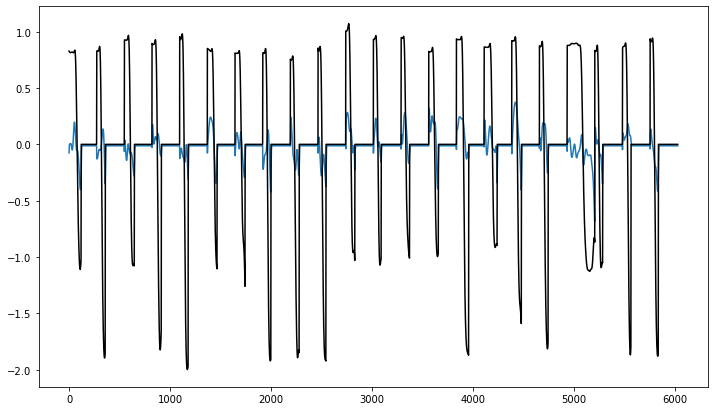

In [79]:
plt.figure(figsize=(12,7))
plt.plot(y_pred[:,5])
plt.plot(y_test[:,5], color='k')

torch.Size([11, 273, 6])

In [67]:
#Evaluate trained model
rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

#Evaluate trained model
rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

# rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
# rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

In [17]:
def run_rnn(pred_df, neural_df, neural_offset, task_info=True, window_size=10, num_cat=0):
  if task_info:
    exclude_processing = np.zeros(len(neural_df['unit'].unique()))
    exclude_processing[-num_cat:] = np.ones(num_cat)
    exclude_processing = exclude_processing.astype(bool)
  else:
    exclude_processing = None

  data_arrays, generators = mocap_functions.make_generators(
    pred_df, neural_df, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=True)
  
  # Unpack tuple into variables
  training_set, validation_set, testing_set = data_arrays
  training_generator, training_eval_generator, validation_generator, testing_generator = generators

  X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
  y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

  X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
  y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

  #Define hyperparameters
  lr = 1e-4
  weight_decay = 1e-2
  hidden_dim = 100
  dropout = 0.5
  n_layers = 2
  max_epochs = 1000
  input_size = training_set[0][0].shape[1] 
  output_size = training_set[0][1].shape[1] 


  # model_rnn = mocap_functions.model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device).to(device)
  model_rnn = model_gru(input_size, output_size, hidden_dim, n_layers, dropout, device, cat_features=exclude_processing).to(device)

  # Define Loss, Optimizerints h
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model_rnn.parameters(), lr=lr, weight_decay=weight_decay)

  #Train model
  loss_dict = mocap_functions.train_validate_model(model_rnn, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  #Evaluate trained model
  rnn_train_pred = mocap_functions.evaluate_model(model_rnn, training_eval_generator, device)
  rnn_test_pred = mocap_functions.evaluate_model(model_rnn, testing_generator, device)

  rnn_train_corr = mocap_functions.matrix_corr(rnn_train_pred, y_train_data)
  rnn_test_corr = mocap_functions.matrix_corr(rnn_test_pred, y_test_data)

  return rnn_train_pred, rnn_test_pred, rnn_train_corr, rnn_test_corr